### DATA ANALYSIS TEXTBOOK
#### Chapter 15
---
##### CART
##### Used cars
---

In [76]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import seaborn as sns
from mizani.formatters import percent_format
import os
from plotnine import *
import numpy as np
import sys
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from stargazer import stargazer
from statsmodels.tools.eval_measures import mse,rmse

# Imports
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.externals.six import StringIO
from IPython.display import Image, display
import pydotplus


In [25]:
# Current script folder
current_path = os.getcwd()
dirname = "/".join(current_path.split("/")[:-2]) + "/"

# location folders
data_in = dirname + "da_data_repo/used-cars/clean/"
data_out = dirname + "da_case_studies/ch15-used-cars-cart/"
output = dirname + "da_case_studies/ch15-used-cars-cart/output/"
func = dirname + "da_case_studies/ch00-tech-prep/"
sys.path.append(func)

In [3]:
# Import the prewritten helper functions
from py_helper_functions import *

In [12]:
# DATA IMPORT
data = pd.read_csv(data_in + "used-cars_2cities_prep.csv")

In [13]:
# SAMPLE DESIGN

# Manage missing
data["fuel"] = data["fuel"].fillna("Missing")
data["drive"] = data["drive"].fillna("Missing")
data["cylinders"] = data["cylinders"].fillna("Missing")
data["transmission"] = data["transmission"].fillna("Missing")
data["type"] = data["type"].fillna("Missing")

In [14]:
data['condition'].value_counts()

excellent    139
good         114
like new      55
fair          15
new            4
Name: condition, dtype: int64

In [15]:
data["condition"] = data["condition"].fillna("good")

In [16]:
data['condition'].value_counts()

good         336
excellent    139
like new      55
fair          15
new            4
Name: condition, dtype: int64

In [20]:
# drop hybrid models then drop column
data = (data.query("Hybrid==0")).drop(["Hybrid"], axis=1)

# keep gas-fuelled vehicles
data = data.query("fuel=='gas'")

# drop vehicles in fair and new condition, trucks
data = data.query("condition not in ['new','fair']")

# drop unrealistic values for price and odometer reading
data = data.query("price in @seq(500,25001,by=1)").query("odometer<=100")

# drop if price is smaller than 1000 and condition is like new or age is less than 8
data = data.query("~(price < 1000 & (condition == 'like new'|age < 8))")

data = data.query("~(transmission=='manual')")

# drop if truck
data = data.query("type not in ['truck','pickup']")

# drop pricestr
data = data.drop(["pricestr"], axis=1)

In [52]:
# to be on the safe side
data = data[data["price"].notna()]
data = data.reset_index()

In [53]:
# DATA GENERATION & DESCRIPTIVES
# CONDITION
data["cond_excellent"] = np.where(data["condition"] == "excellent", 1, 0)
data["cond_good"] = np.where(data["condition"] == "good", 1, 0)
data["cond_likenew"] = np.where(data["condition"] == "like new", 1, 0)
# cylinders
data["cylind6"] = np.where(data["cylinders"] == "6 cylinders", 1, 0)
data.cylinders.value_counts()
data.cylind6.value_counts()
#chicago
data["chicago"] = np.where(data["area"] == "chicago", 1, 0)
# age: quadratic, cubic
data["agesq"] = data["age"] ** 2
data["agecu"] = data["age"] ** 3
# odometer quadratic
data["odometersq"] = data["odometer"] ** 3
data.to_csv("usedcars_work.csv",index=False)

In [54]:
data.price.describe()

count      477.000000
mean      5843.878407
std       4334.571604
min        500.000000
25%       2500.000000
50%       4400.000000
75%       8300.000000
max      18500.000000
Name: price, dtype: float64

In [55]:
smp_size=np.floor(0.7*data.shape[0])


In [56]:
import random
# Initialize random seed to make it reproducible
random.seed(20180122)
train_ids= random.sample(range(0, data.shape[0]), int(smp_size))

In [57]:
data["train"]=0
data["train"][train_ids]=1

In [59]:
data["train"].value_counts()

1    333
0    144
Name: train, dtype: int64

In [60]:
data_train = data.query('train==1')
data_test = data.query('train==0')

### Regression tree
---

In [62]:
data_train.price.describe()

count      333.000000
mean      5714.477477
std       4403.355921
min        500.000000
25%       2400.000000
50%       3980.000000
75%       8300.000000
max      18500.000000
Name: price, dtype: float64

In [83]:
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor(random_state=2018,max_depth=1)

In [84]:
# Note X should be a matrix instead of series, that's why we need double []
X=data_train[['age']]
Y=data_train['price']
regressor.fit(X,Y)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=1,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=2018, splitter='best')

In [86]:
pred_cart1 = regressor.predict(data_test[["age"]])

rmse_cart1 = np.sqrt(mean_squared_error(data_test["price"], pred_cart1))

In [81]:
def jupyter_graphviz(m, **kwargs):
    dot_data = StringIO()
    export_graphviz(m, dot_data, **kwargs)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    display(Image(graph.create_png()))

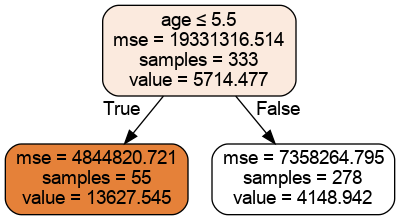

In [85]:
jupyter_graphviz(regressor,filled=True,rounded=True,special_characters=True,feature_names=['age'])

In [92]:
### Scatterplot with step function
plot_helper=seq(min(data_train['age']),max(data_train['age']),by=1)

plot_helper_df=pd.DataFrame({"age":plot_helper})
plot_helper_df['xend']=pd.Series(plot_helper)+1
plot_helper_df['yend']=regressor.predict(plot_helper_df[['age']])
pred_cart1t = regressor.predict(data_train[['age']])

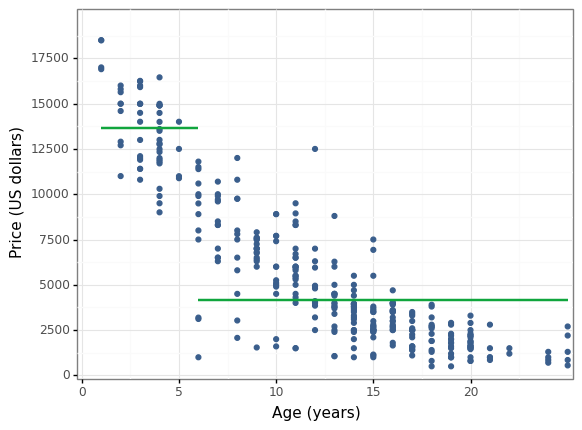

<ggplot: (8745306879275)>

In [107]:
ggplot(data_train, aes(x="age", y="price")) + geom_point(color=color[0]) + geom_segment(
    plot_helper_df,
    aes(x="age", y="yend", xend="xend", yend="yend"),
    color=color[1],
    size=1,
    na_rm=True,
) + scale_y_continuous(
    expand=(0.01, 0.01), limits=(0, 20000), breaks=seq(0, 20000, by=2500)
) + scale_x_continuous(
    expand=(0.01, 0.01), limits=(0, 25), breaks=seq(0, 25, by=5)
) + labs(
    x="Age (years)", y="Price (US dollars)"
) + theme_bw()

In [ ]:
###########
# Splits at two levels
# (make sure it stops by setting "max_depth" to 2)

In [108]:
regressor = DecisionTreeRegressor(random_state=2018,max_depth=2)
# Note X should be a matrix instead of series, that's why we need double []
X=data_train[['age']]
Y=data_train['price']
regressor.fit(X,Y)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=2018, splitter='best')

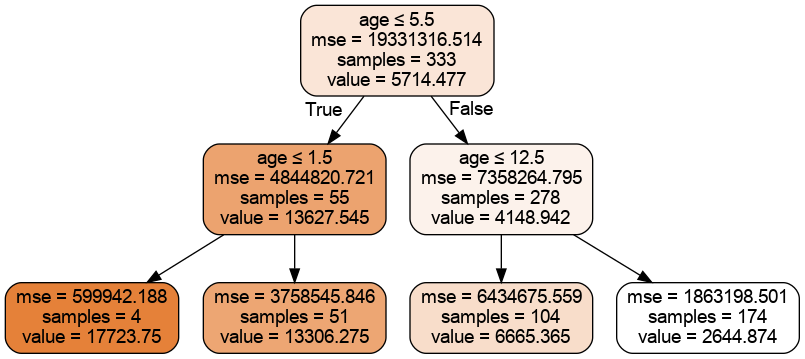

In [109]:
jupyter_graphviz(regressor,filled=True,rounded=True,special_characters=True,feature_names=['age'])

In [157]:
# Cut points
cuts = regressor.tree_.threshold[regressor.tree_.threshold != -2][
    -regressor.get_depth() :
]
# Groups
groups = []
for x in cuts:
    groups += [int(np.floor(x)), int(np.floor(x) + 1)]

In [163]:
groups=sorted(groups)+['and more']

In [181]:
from collections import Counter

# get the leaf for each training sample
leaves_index = regressor.apply(X)

# use Counter to find the number of elements on each leaf
cnt = Counter(sorted(leaves_index))

# and now you can index each input to get the number of elements
elems = [cnt[x] for x in leaves_index]

In [185]:
counts=list(cnt.values())

In [196]:
av_price = (
    pd.DataFrame({"index": leaves_index, "fit": regressor.predict(X)})
    .drop_duplicates()
    .sort_values("index")["fit"]
    .tolist()
)

In [197]:
pd.DataFrame(
    {
        "Category": [
            "Age " + str(groups[i]) + "-" + str(groups[i + 1])
            for i in range(len(groups) - 1)
        ],
        "Count": counts,
        "Average_price": av_price
    }
)

,Category,Count,Average_price
0,Age 1-2,4,17723.750000
1,Age 2-12,51,13306.274510
2,Age 12-13,104,6665.365385
3,Age 13-and more,174,2644.873563


In [212]:
data_train.loc[(data_train.age>1)&(data_train.age<12),:].shape

(142, 31)

In [213]:
pred_cart2 = regressor.predict(data_test[["age"]])

rmse_cart2 = np.sqrt(mean_squared_error(data_test["price"], pred_cart2))

In [214]:
### Scatterplot with step function
plot_helper=seq(min(data_train['age']),max(data_train['age']),by=1)

plot_helper_df=pd.DataFrame({"age":plot_helper})
plot_helper_df['xend']=pd.Series(plot_helper)+1
plot_helper_df['yend']=regressor.predict(plot_helper_df[['age']])
pred_cart1t = regressor.predict(data_train[['age']])

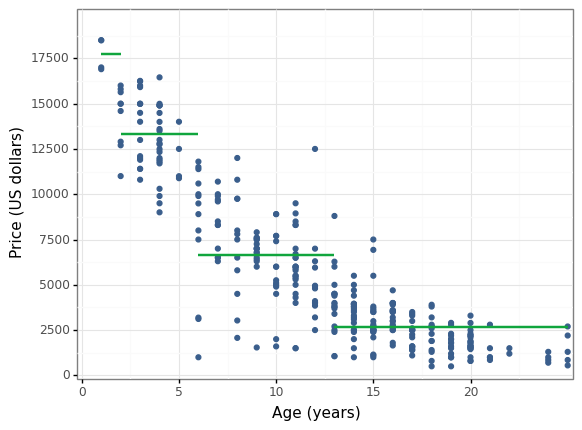

<ggplot: (8745302817877)>

In [216]:
ggplot(data_train, aes(x="age", y="price")) + geom_point(color=color[0]) + geom_segment(
    plot_helper_df,
    aes(x="age", y="yend", xend="xend", yend="yend"),
    color=color[1],
    size=1,
    na_rm=True,
) + scale_y_continuous(
    expand=(0.01, 0.01), limits=(0, 20000), breaks=seq(0, 20000, by=2500)
) + scale_x_continuous(
    expand=(0.01, 0.01), limits=(0, 25), breaks=seq(0, 25, by=5)
) + labs(
    x="Age (years)", y="Price (US dollars)"
) + theme_bw()


In [217]:
### Splits go on
regressor = DecisionTreeRegressor(random_state=2018,max_depth=3)
# Note X should be a matrix instead of series, that's why we need double []
X=data_train[['age']]
Y=data_train['price']
regressor.fit(X,Y)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=3,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=2018, splitter='best')

In [219]:
pred_cart3 = regressor.predict(data_test[["age"]])

rmse_cart3 = np.sqrt(mean_squared_error(data_test["price"], pred_cart3))

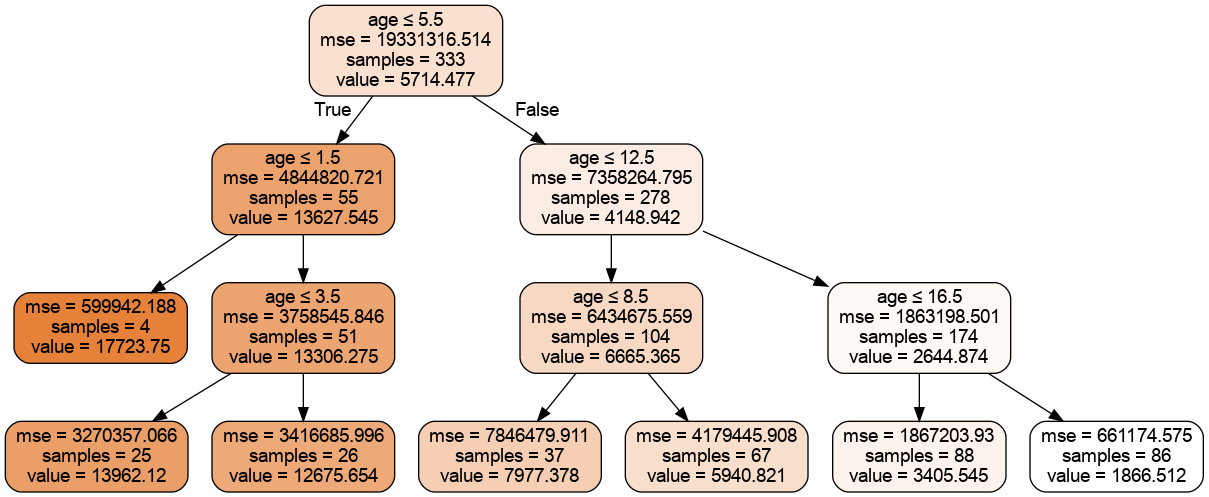

In [220]:
jupyter_graphviz(regressor,filled=True,rounded=True,special_characters=True,feature_names=['age'])

In [221]:
### Scatterplot with step function
plot_helper=seq(min(data_train['age']),max(data_train['age']),by=1)

plot_helper_df=pd.DataFrame({"age":plot_helper})
plot_helper_df['xend']=pd.Series(plot_helper)+1
plot_helper_df['yend']=regressor.predict(plot_helper_df[['age']])
pred_cart1t = regressor.predict(data_train[['age']])

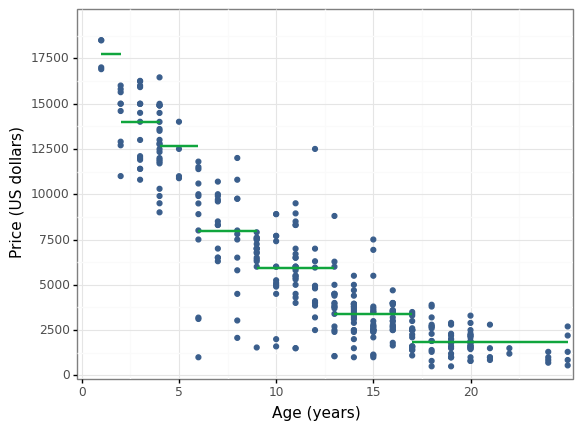

<ggplot: (8745300133488)>

In [222]:
ggplot(data_train, aes(x="age", y="price")) + geom_point(color=color[0]) + geom_segment(
    plot_helper_df,
    aes(x="age", y="yend", xend="xend", yend="yend"),
    color=color[1],
    size=1,
    na_rm=True,
) + scale_y_continuous(
    expand=(0.01, 0.01), limits=(0, 20000), breaks=seq(0, 20000, by=2500)
) + scale_x_continuous(
    expand=(0.01, 0.01), limits=(0, 25), breaks=seq(0, 25, by=5)
) + labs(
    x="Age (years)", y="Price (US dollars)"
) + theme_bw()


#### Age only linear regression
---

In [226]:
linreg1=smf.ols("price~age",data=data_train).fit()
linreg1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.748
Model:                            OLS   Adj. R-squared:                  0.747
Method:                 Least Squares   F-statistic:                     981.5
Date:                Tue, 08 Dec 2020   Prob (F-statistic):          4.91e-101
Time:                        14:09:04   Log-Likelihood:                -3036.6
No. Observations:                 333   AIC:                             6077.
Df Residuals:                     331   BIC:                             6085.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.362e+04    280.108     48.636      0.000    1.31e+04    1.42e+04
age         -640.1756     20.434    -31.329      0.000    -680.373    -599.978
==============================================================================
Omnibus:                       11.666   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               23.217
Skew:                          -0.091   Prob(JB):                     9.09e-06
Kurtosis:                       4.281   Cond. No.                         31.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [228]:
pred_linreg1=linreg1.predict(data_test)
rmse=np.sqrt(mean_squared_error(data_test['price'],pred_linreg1))

In [229]:
## Scatterplot with predicted values
pred_linreg1t=linreg1.predict(data_train)

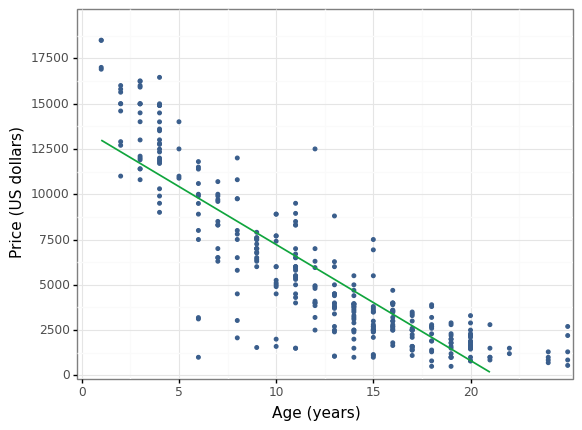

<ggplot: (8745295134534)>

In [230]:
ggplot(data_train) + geom_point(
    aes(x="age", y="price"),
    color=color[0],
    size=1,
    alpha=0.7,
    show_legend=False,
    na_rm=True,
) + geom_line(
    aes(x="age", y="pred_linreg1t"), colour=color[1], size=0.7
) + scale_y_continuous(
    expand=(0.01, 0.01), limits=(0, 20000), breaks=seq(0, 20000, by=2500)
) + scale_x_continuous(
    expand=(0.01, 0.01), limits=(0, 25), breaks=seq(0, 25, by=5)
) + labs(
    x="Age (years)", y="Price (US dollars)"
) + theme_bw()


In [234]:
#### Age only only lowess
lowess = sm.nonparametric.KernelReg

In [240]:
lowess1=lowess(data_train.price,data_train.age,"c")

In [ ]:
pred_lowess1=lowess1.fit(data_test['age'])
rmse_lowess1=np.sqrt(mean_squared_error(data_test['price'],pred_lowess1[0]))
pred_lowess1t=lowess1.fit(data_train['age'])

In [256]:
data_lowess=data_train.copy()
data_lowess['pred_lowess1t']=pred_lowess1t[0]

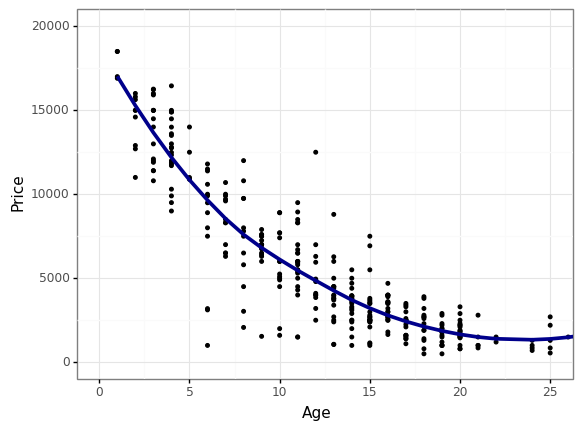

<ggplot: (8745309066768)>

In [251]:
ggplot(data_train, aes(x="age", y="price")) + geom_point(size=1, colour="black") + labs(
    x="Age", y="Price"
) + coord_cartesian(xlim=(0, 25), ylim=(0, 20000)) + geom_smooth(
    method="loess", colour="darkblue", se=False, size=1.5
) + theme_bw()


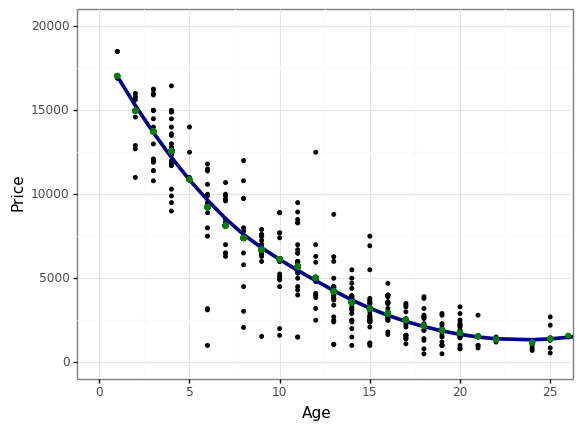

<ggplot: (8745300118571)>

In [261]:
### Checking kernelreg predictions (green points) - they look the same as loess method results.
ggplot(data_lowess, aes(x="age", y="price")) + geom_point(size=1, colour="black") + labs(
    x="Age", y="Price"
) + coord_cartesian(xlim=(0, 25), ylim=(0, 20000)) + geom_smooth(
    method="loess", colour="darkblue", se=False, size=1.5
) + theme_bw()+geom_point(aes(x="age",y="pred_lowess1t"),color="green")

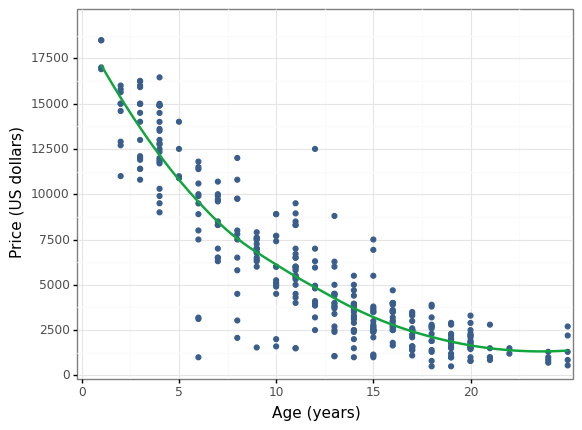

<ggplot: (8745294828632)>

In [263]:
ggplot(data_train, aes(x="age", y="price")) + geom_point(color=color[0]) + geom_smooth(
    color=color[1], method="loess", se=False
) + scale_y_continuous(
    expand=(0.01, 0.01), limits=(0, 20000), breaks=seq(0, 20000, by=2500)
) + scale_x_continuous(
    expand=(0.01, 0.01), limits=(0, 25), breaks=seq(0, 25, by=5)
) + labs(
    x="Age (years)", y="Price (US dollars)"
) + theme_bw()


In [ ]:
## Not finished, you can find the last part from line 334 to 489 in R